# Продвинутый Python, Семинар 4

**Лектор:** Садуллаев Музаффар

**Семинаристы:** Бобоев Мурод, Богданов Сергей, Васина Олеся, Дергачев Cтепан, Какурин Василий, Садуллаев Музаффар, Солодовников Михаил

**In our heart**: Петров Тимур

**Spoiler Alert:** в рамках курса нельзя изучить ни одну из тем от и до досконально (к сожалению, на это требуется больше времени, чем даже 3 часа в неделю). Но мы попробуем рассказать столько, сколько возможно :)

## Один Поток (Singlethread) / Многопоточность (Multithread) / Мультипроцессинг (Multiprocess)

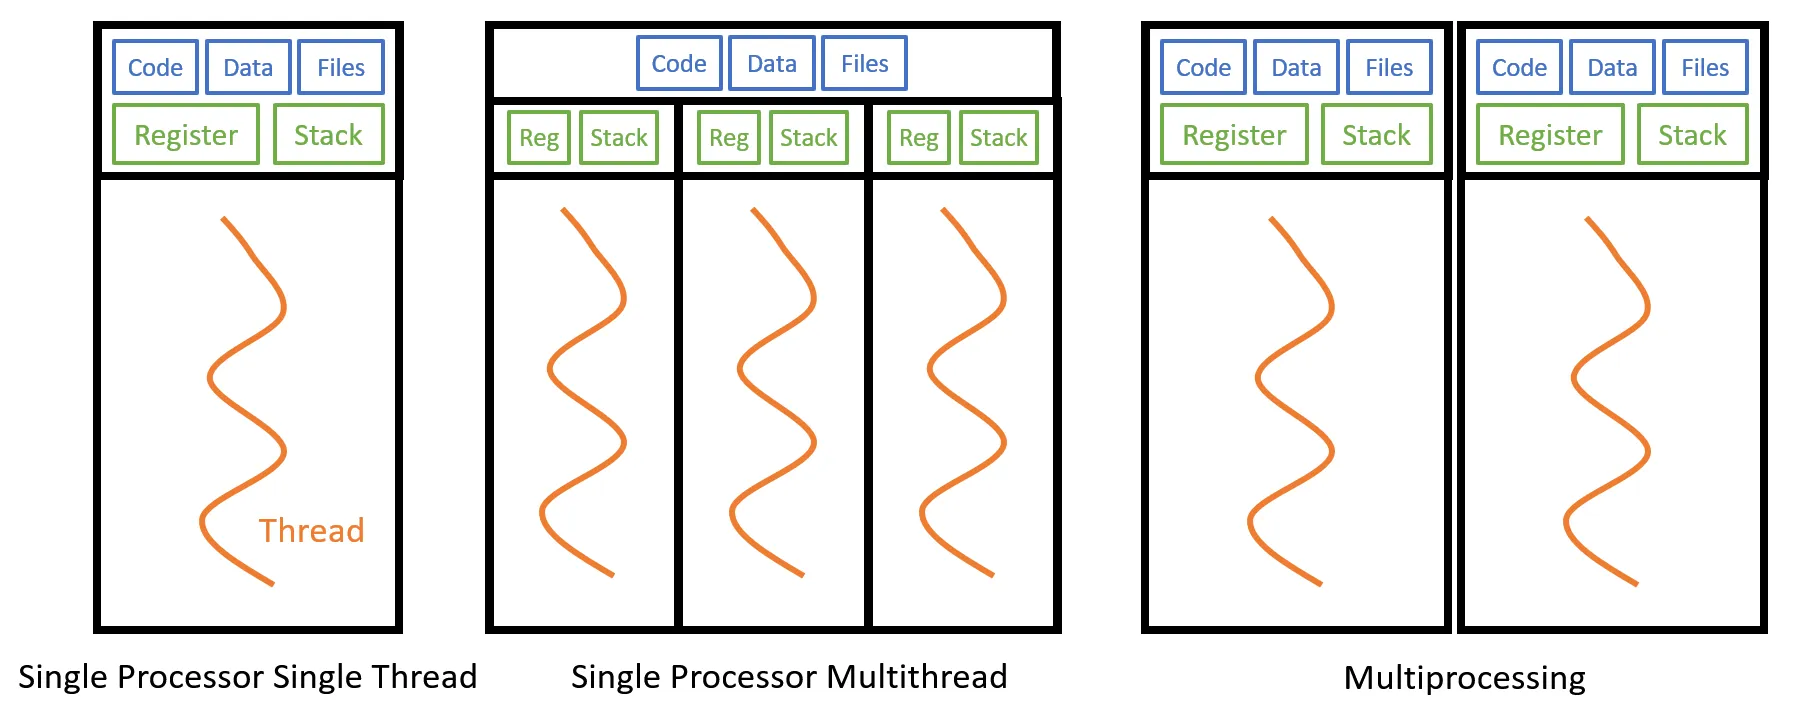
[click for source](https://towardsdatascience.com/multithreading-and-multiprocessing-in-10-minutes-20d9b3c6a867#:~:text=By%20formal%20definition%2C%20multithreading%20refers,run%20one%20or%20more%20threads)


Как работает программа в однопроцессном однопоточном режиме. 

Когда мы запускаем программу, операционная система:

- создаёт **процесс** — контейнер для выполнения кода;

- загружает в память код (инструкции, которые выполняет ЦПУ) и данные программы;

- выделяет ресурсы (стек / динамическая память, файловые дескрипторы);

- создаёт **поток выполнения**.

В однопоточном режиме у программы есть только один поток:

- процессор выполняет инструкции **строго последовательно**;

- у потока есть свой **стек** (для локальных переменных и вызовов функций);

- объекты, созданные динамически, хранятся в **куче** (общей для всего процесса);

- пока поток занят, программа не может делать ничего другого (например, если программа делает долгий запрос в интернет, весь процесс "зависает", пока не придёт ответ).

Команды программы выполняются процессором. Современные процессоры имеют несколько ядер - исполнителей для ускорения вычислений. В однопоточном режиме мы 
не можем задействовать эти ядра. Режим многопоточности позволяет использовать несколько ядер. 

Внутри каждого процесса можно запустить нескольно потоков: у каждого потока будут свои виртуальные регистры и свой стек для хранения локальных переменных, 
фреймов функций и тд. Это позволяет нам иметь у каждого потока свои значения переменных, но при этом все они запускают одинаковый код, и видят одинаковые данные (например, динамическая память у нас общая на все потоки внутри одного процесса). ОС и ЦПУ планируют выполнение программы так, что эти потоки могут работать либо поочередно (на одном ядре; concurrent execution), либо параллельно (на разных ядрах). 

В многопроцессном режиме у нас есть несколько запущенных процессов, при этом в каждом процессе может быть несколько потоков. Все процессы изолированы друг от друга и не могут вмешиваться в работу друг друга.

## Потоки (thread)

### GIL

Напомню, что мы выучили на лекции, что в python существует GIL (Global interpreter lock) и он капитально портит нам жизнь если мы запускаем нескольно потоков внутри python процесса:

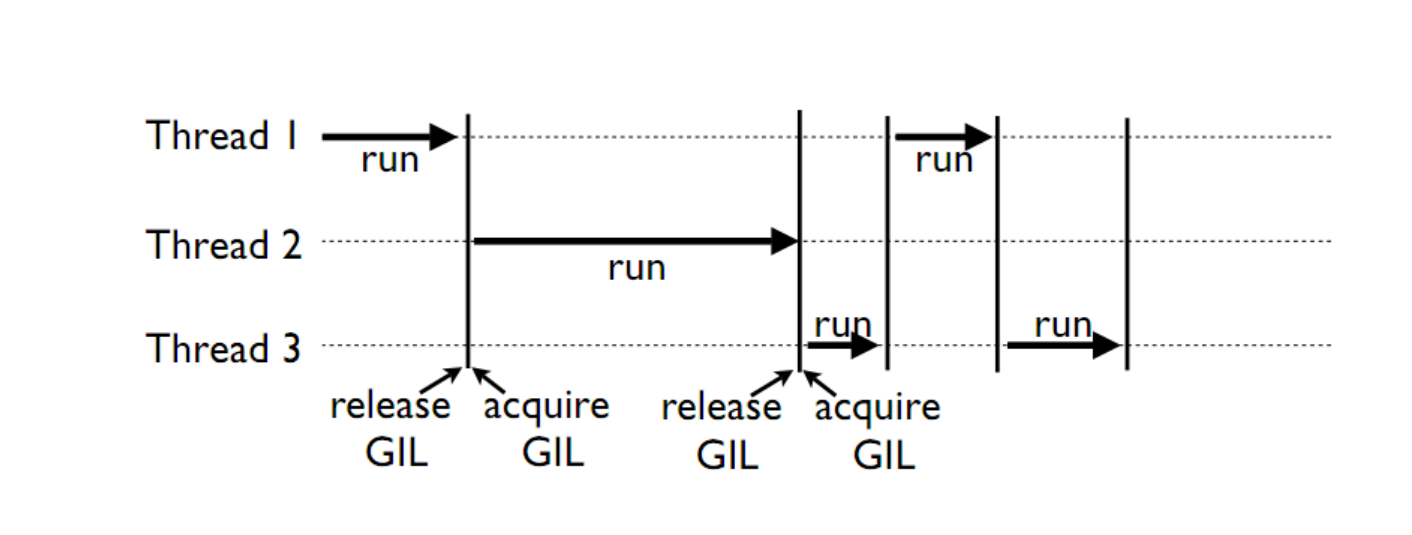

> "In CPython, the global interpreter lock, or GIL, is a mutex that protects access to Python objects, preventing multiple threads from executing Python bytecodes at once. This lock is necessary mainly because CPython's memory management is not thread-safe."



То есть в CPython - одной из реализаций интерпретатора Python - есть встроенный механизм, который обеспечивает выполнение ровно одного потока в любой момент 

времени. Благодаря такому ограничению CPython имеет относительно лёгкую реализацию, когда объекты Python'а защищены от одновременного доступа из нескольких

 потоков. Таким образом, если создать несколько потоков одновременно, то они не будут выполняться параллелльно на разных ядрах процессора. То есть 
 
 распараллелить вычисления с помощью CPython невозможно. Но есть исключения: GIL "отключается", когда мы параллелим задачи, связанные с вводом-выводом
 
  информации (например, чтение из / запись в файл), операции с базами данных, HTTP запросы (см. пример с лекции). 

#### No-GIL build

Запустим следующий код сперва "обычным" интерпретатором Python, а потом - без поддержки GIL.

In [1]:
%%writefile nogil_test.py

import time
import threading

import sys

# Print Python version
print(f"Python version: {sys.version_info}")

# A simple function to simulate a CPU-bound task
def cpu_bound_task(n):
    total = 0
    for i in range(n):
        total += i
    print(f"Task finished, result: {total}")

if __name__ == "__main__":
    N = 10**7

    # Start multiple threads to simulate parallelism
    start_time = time.time()
    threads = []
    for _ in range(4):
        thread = threading.Thread(target=cpu_bound_task, args=(N,))
        threads.append(thread)
        thread.start()

    # Wait for all threads to finish
    for thread in threads:
        thread.join()

    end_time = time.time()

    print(f"Time taken: {end_time - start_time:.2f} seconds")


Overwriting nogil_test.py


In [2]:
!python3.13 nogil_test.py

Python version: sys.version_info(major=3, minor=13, micro=5, releaselevel='final', serial=0)
Task finished, result: 49999995000000
Task finished, result: 49999995000000
Task finished, result: 49999995000000Task finished, result: 49999995000000

Time taken: 0.76 seconds


Находим что через `pyenv` можно [поставить](https://stackoverflow.com/questions/79122522/how-to-disable-the-gil-in-python3-13) no-gil версию. Так давайте поставим!

In [3]:
!pyenv --version
!pyenv install 3.13t-dev -s

pyenv 2.6.8


In [4]:
!python -c "import sys; print(sys.version)"

3.13.5 | packaged by Anaconda, Inc. | (main, Jun 12 2025, 11:23:37) [Clang 14.0.6 ]


In [7]:
!python3 --version

Python 3.13.7+


In [8]:
!python3 nogil_test.py

Python version: sys.version_info(major=3, minor=13, micro=7, releaselevel='final', serial=0)
Task finished, result: 49999995000000
Task finished, result: 49999995000000
Task finished, result: 49999995000000
Task finished, result: 49999995000000
Time taken: 0.27 seconds


Ну что, мы увидели что потоки часто ждут (idle) выполнения других, более того видно что вообще никогда потоки не выполняются одновременно (в стабильной версии Python с поддержкой GIL), собственно потому что потоки используют один интерпретатор внутри.

**Зачем тогда нужны потоки вообще?**

Короткий ответ: для операции ввода/вывода.

### Как создавать

In [9]:
import threading
import time

def worker(name):
    print(f"Start {name}")
    time.sleep(1)
    print(f"End {name}")


t1 = threading.Thread(target=worker, args=("A",))
t2 = threading.Thread(target=worker, args=("B",))

t1.start()
t2.start()

t1.join()
t2.join()
print("Done")

Start AStart B

End A
End B
Done


В чем проблемы?

* надо самим управлять созданием и завершением потоков
* если задач много, вручную делать сотни Thread неудобно, объект тяжелый
* нет управления


### ThreadPool Executor

In [ ]:
# Module concurrent.futures gives high-level interface for asynchronously executing callables (using threads)
from concurrent.futures import ThreadPoolExecutor
import time

def worker(name):
    print(f"Start {name} \n")
    time.sleep(1)
    print(f"End {name} \n")

# ThreadPoolExecutor - класс, использующий пул из максимум max_workers потоков для асинхронного выполнения
# использование менеджера контекста позволяет автоматически отслеживать завершение выполнения всех потоков, запущенных внутри
with ThreadPoolExecutor(max_workers=3) as executor:
    names = ["A", "B", "C", "D", "E"]
    executor.map(worker, names)

print("Done")

Start AStart B

Start C
End CEnd B
Start D
End A
Start E

End DEnd E

Done


* мы не создаём потоки руками
* пул ограничен 3 потоками
* задачи A..E автоматически распределяются по пулу.

### Race conditions


Ну что же давай-то посмотрим что происходит, если threadы не блокируют GIL и по-настоящему запускаются параллельно:

In [ ]:
import threading
import sys


def thread_job(number):
    # Выводим в stdout, flush=True делает его non-blocking (то есть сообщение мы помещаем в буфер, а буфер сразу же выводим на печать)
    print('Hello {} \n'.format(number), flush=True) 


def run_threads(count):
    threads = [
        threading.Thread(target=thread_job, args=(i,)) # создаем count потоков, назначаем, что каждый должен делать, можем отдельно передавать аргументы
        for i in range(0, count)
    ]
    for thread in threads:
        thread.start()  # каждый поток должен быть запущен
    for thread in threads:
        thread.join()  # дожидаемся исполнения всех потоков (можем не дожидаться, дождаться надо, потому что может закончиться родительский тред)


run_threads(25)
print("finish") #А тут уже что-то перемешалось (потому что поток вывода один)

Hello 0
Hello 1
Hello 2
Hello 3
Hello 4
Hello 5
Hello 6
Hello 7
Hello 8
Hello 9
Hello 10
Hello 11
Hello 12
Hello 13
Hello 14
Hello 15
Hello 16
Hello 17
Hello 18
Hello 19
Hello 20
Hello 21
Hello 22
Hello 23
Hello 24
finish


Месиво какое-то.. А что если попытаться считать?

In [ ]:
import threading
import random
import time
import sys


def thread_job():
    global counter # хранится в памяти, общей для всех потоков данного процесса; 
                   # в теории ОС эта переменная называется критическим ресурсом, то есть в каждый момент времени к ней должен иметь доступ только один поток;
                   # а участок кода, в котором происходит работа с таким ресурсом, называется критическая секция / интервал;
                   # конкуренция потоков за доступ к критическому ресурсу называется состоянием гонки (race condition); 
    old_counter = counter
    time.sleep(random.randint(0, 1)) #засыпаем, чтобы вызвать проблему
    counter = old_counter + 1
    print('{} '.format(counter), end='')
    sys.stdout.flush()


counter = 0
threads = [threading.Thread(target=thread_job) for _ in range(4)]
for thread in threads:
    thread.start()
for thread in threads:
    thread.join()
print(counter)

1 2 2 3 3


Не работает! Для того чтобы починить принято использовать locks, например mutex (самый простой лок)

В целом такая ситуация называется race condition.

Lock блокирует использование ресурсов на время выполнения контекста (собственно того что залочено)

In [ ]:
import threading
import random
import time
import sys


def thread_job():
    with lock: # Входим и блокируем ресурсы
        # то есть в каждый момент времени в критической секции находится только один поток
        global counter 
        old_counter = counter
        time.sleep(random.randint(0, 1))
        counter = old_counter + 1
        print('{} '.format(counter), end='')
        sys.stdout.flush()


lock = threading.Lock()
counter = 0
threads = [threading.Thread(target=thread_job) for _ in range(4)]
for thread in threads:
    thread.start()
for thread in threads:
    thread.join()
print(counter)

1 2 3 4 4


Есть некоторые проблемы с использованием lock налево и направо:

* вычисления могут перестать быть асинхронными

* deadlock / тупик - ситуация, когда из-за некорректной организации доступа к разделяемому ресурсу конкурирующие потоки взаимно блокируются. 

***Пример.*** Пусть есть два потока A и B и два критических ресурса C и D. Поток A входит в критическую секцию ресурса C, соответственно, ресурс C блокируется 

для доступа остальными потоками, в том числе потоком B. А поток B входит в критическую секцию ресурса D, соответственно, ресурс D блокируется для доступа 

остальными потоками, в том числе, потоком A. Далее поток A, находясь в критической секции ресурса C, решает обратиться к ресурсу D, а тот заблокирован потоком 

B; следовательно, поток A зависает и ожидает освобождения ресурса D. В то же время поток B, находясь в критической секции ресурса D, решает обратиться к р

ресурсу C, а тот заблокирован потоком A; следовательно, поток B зависает в ожидании освобождения ресурса C. В итоге, имеем, что оба потока зависли, ожидая 

освобождения ресурсов друг у друга, чего не произойдёт никогда. 


Кроме lock, в типичную парадигму асинхронных вычислений входит ***semaphore (светофор)***, lock cо счётчиком.

Семафор - специальный целочисленный тип данных, над которыми определены две атомарные операции (то есть эти операции неделимые, либо выполняются от начала и 

до конца, либо не выполняются ни в каком виде):

1) down = опустить семафор;

2) up = поднять семафор.

Down проверяет значение переменной семафора: если оно больше нуля, то уменьшается на 1; если нет, то поток блокируется до освобождения ресурса;

Up увеличивает значение переменной семафора на 1: если како-то поток был заблокирован ранее, то он разблокируется и завершит свою операцию down

Вот так это делается в питоне.

In [ ]:
import threading

# Создадим semaphore
# atomic counter = (number of release()) - (number of acquire()) + value=3
# value - default value of counter (default = 1, here 3)
# то есть 3 потока могут одновременно находиться в к критической секции
semaphore = threading.Semaphore(3)


def access_shared_resource(thread_id):
    print(f"Thread {thread_id} пытается начать работу!\n")

    semaphore.acquire() # операция Down, уменьшает счётчик на 1

    print(f"Thread {thread_id} заблокировал semaphore.\n")

    # Поспим :)
    time.sleep(1)

    # Отпустим semaphore
    semaphore.release() # операция Up
    print(f"Thread {thread_id} отпустил semaphore.\n")

threads = []
for i in range(5):
    thread = threading.Thread(target=access_shared_resource, args=(i,))
    threads.append(thread)
    thread.start()

for thread in threads:
    thread.join()

Thread 0 пытается начать работу!
Thread 0 заблокировал semaphore.
Thread 1 пытается начать работу!
Thread 1 заблокировал semaphore.
Thread 2 пытается начать работу!
Thread 2 заблокировал semaphore.
Thread 3 пытается начать работу!
Thread 4 пытается начать работу!
Thread 0 отпустил semaphore.Thread 2 отпустил semaphore.
Thread 1 отпустил semaphore.
Thread 3 заблокировал semaphore.
Thread 4 заблокировал semaphore.

Thread 3 отпустил semaphore.Thread 4 отпустил semaphore.



Задачка на использование будет в домашке :)

Смысл семафора чтоб не разрешать слишком большому числу ресурсов пользоваться cpu (скажем например отправлять что-то через network)

Ура, изучили lock, дальше увидим пример уже в задачках :)

### Философы и deadlock

Задача обедающих философов - классическая задача синхронизации работы потоков, которая решается грамотным применением семафоров. 

За круглым столом обедают 4 философa (thread), берут вилку в обе руки за обедом, вилок тоже 4. Как философ поел, он размышляет, потом пытается поесть снова, поскольку как истинный философ он ненасытен. Однако, если философ не может поесть он проклинает программиста. Попробуйте избежать проклятия :)

In [ ]:
import threading

num_philosophers = 4
forks = [threading.Lock() for _ in range(num_philosophers)]
update_lock = threading.Lock()
statuses = [0] * num_philosophers

def check_status():
    with update_lock:
      return sum(statuses) != num_philosophers

def philosopher(i):
    print(f'Philosopher {i} wants to eat: {statuses} \n', flush=True)
    while check_status():
        # Взяли палочки-вилочки
        forks[i].acquire()
        forks[(i + 1) % num_philosophers].acquire()

        # Покушали
        time.sleep(((i % 2) + 0.1) * 0.5)
        with update_lock:
            statuses[i] = 1
            print(f'Philosopher {i} finished: {statuses} \n', flush=True)

        # Вернули
        forks[i].release()
        forks[(i + 1) % num_philosophers].release()


philosophers = [threading.Thread(target=philosopher, args=(i,)) for i in range(num_philosophers)]
for p in philosophers:
    p.start()
for p in philosophers:
    p.join()

Philosopher 2 finished: [0, 0, 1, 0]
Philosopher 0 finished: [1, 0, 1, 0]
Philosopher 3 finished: [1, 0, 1, 1]
Philosopher 2 finished: [1, 0, 1, 1]
Philosopher 1 finished: [1, 1, 1, 1]
Philosopher 0 finished: [1, 1, 1, 1]
Philosopher 3 finished: [1, 1, 1, 1]
Philosopher 2 finished: [1, 1, 1, 1]


Ладно, запустим с 5ью!

In [16]:
import threading

num_philosophers = 5
forks = [threading.Lock() for _ in range(num_philosophers)]
update_lock = threading.Lock()
statuses = [0] * num_philosophers


philosophers = [threading.Thread(target=philosopher, args=(i,)) for i in range(num_philosophers)]
for p in philosophers:
    p.start()
for p in philosophers:
    p.join()

Philosopher 2 finished: [0, 0, 1, 0, 0]
Philosopher 0 finished: [1, 0, 1, 0, 0]
Philosopher 4 finished: [1, 0, 1, 0, 1]
Philosopher 3 finished: [1, 0, 1, 1, 1]
Philosopher 2 finished: [1, 0, 1, 1, 1]
Philosopher 1 finished: [1, 1, 1, 1, 1]
Philosopher 0 finished: [1, 1, 1, 1, 1]
Philosopher 4 finished: [1, 1, 1, 1, 1]
Philosopher 3 finished: [1, 1, 1, 1, 1]
Philosopher 2 finished: [1, 1, 1, 1, 1]


В домашке будет задача на полноценную реализацию задачи философов для их произвольного числа. 

Не рассмотрен случай, что два соседних философа не могут есть одновременно. 

## Процессы (multiprocessing)

Пример использования (повторим лекцию немного)

источник: https://kemingy.github.io/blogs/python-multiprocessing/

Процесс - совокупность машинных команд и данных, обрабатываемая ОС и обладающая правами на владение некоторым набором ресурсов (например, исполняемый кодом программы, памятью). ОС для каждого процесса поддерживает его жизненный цикл:

- возникновение процесса (создание / порождение)

- выполнение процесса на процессоре (его обработка)

- ожидание постановки процесса на исполнение процессором (обычно это ожидание какого-то события: окончания обмена данными, ввода данных с экрана и тд)

- завершение процесса (передача его ресурсов обратно ОС)

Лучше иметь несколько процессов, чем потоков, из-за GIL, который блокирует фактически многопоточность.

In [28]:
!man ps

PS(1)                       General Commands Manual                      PS(1)

NAME
     ps – process status

SYNOPSIS
     ps [-AaCcEefhjlMmrSTvwXx] [-O fmt | -o fmt] [-G gid[,gid...]]
        [-g grp[,grp...]] [-u uid[,uid...]] [-p pid[,pid...]]
        [-t tty[,tty...]] [-U user[,user...]]
     ps [-L]

DESCRIPTION
     The ps utility displays a header line, followed by lines containing
     information about all of your processes that have controlling terminals.

     A different set of processes can be selected for display by using any
     combination of the -a, -G, -g, -p, -T, -t, -U, and -u options.  If more
     than one of these options are given, then ps will select all processes
     which are matched by at least one of the given options.

     For the processes which have been selected for display, ps will usually
     display one line per process.  The -M option may result in multiple
     output lines (one line per thread) for some processes.  By default all of
     the

In [ ]:
!ps # посмотреть на все процессы в системе
# process ID | process name | CPU time which was consumed for process | app which ran process

  PID TTY           TIME CMD
  849 ttys000    0:00.01 -bash
 1050 ttys002    0:00.01 /bin/bash --init-file /Applications/Visual Studio Code.
 1051 ttys004    0:00.01 /bin/bash --init-file /Applications/Visual Studio Code.
 1052 ttys006    0:00.01 /bin/bash --init-file /Applications/Visual Studio Code.


Один процесс

In [23]:
%%writefile process_example.py
from multiprocessing import Process

def task():
    print("Hello from process")

if __name__ == "__main__":
    p = Process(target=task)
    p.start()
    p.join()

Overwriting process_example.py


In [24]:
!python process_example.py

Hello from process


Как на лекции (и как chatgpt ответит):

In [25]:
%%writefile multiprocessing_example.py
from multiprocessing import Pool

def my_function(x):
    return x*x


if __name__ == '__main__':
    with Pool() as p:
        result = p.map(my_function, range(10))
        print(result)

Overwriting multiprocessing_example.py


In [26]:
!python multiprocessing_example.py

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]


Через `concurrent.futures`

In [27]:
%%writefile process_pool_executor_example.py
from concurrent.futures import ProcessPoolExecutor
import time

def worker(name):
    print(f"Start {name}")
    time.sleep(1)
    print(f"End {name}")

if __name__ == "__main__":
    with ProcessPoolExecutor(max_workers=3) as executor:
        names = ["A", "B", "C", "D", "E"]
        executor.map(worker, names)

    print("Done")

Overwriting process_pool_executor_example.py


In [7]:
!python process_pool_executor_example.py

Start A
Start B
Start C
End BEnd A
End C

Start D
Start E
End E
End D
Done


На лекции уже был простой пример с multiprocessing. Однако внутри multiprocessing есть подводный камень (спойлер: не один). 

Есть два встроенных алгоритма создания процесса:

* ***spawn***: процесс-родитель создает новый дочерний процесс с запущенным интерпретатором Python; при этом дочерний процесс унаследует лишь часть ресурсов

(например, он не будет наследовать открытые в процессе-родителе файлы).

* ***fork***: Процесс-родитель использует os.fork() чтобы форкнуть Python interpreter. Как только процесс стартует он абсолютно такой же как родитель. Все 

ресурсы унаследованы. В чем проблема? Проблема в том что нужно lockать (как в философах), можно получить state corruption, если в момент forka вы меняли что-то 

в своем процессе... А еще ручная очистка памяти.. Тем не менее оптимальный способ довольно часто.

* ***forkserver***: Заранее сделанный fork n раз. В некотором смысле похоже на работу std::vector с памятью: заранее выделяем себе n процессов, они висят в 

idle до востребования.

#### Зависимость от операционных систем:

Default (что означает что в зависимости от OS программа ведет себя сильно по разному!) :

* Windows (win32): spawn

* macOS (darwin): spawn

* Linux (unix): fork

Более того win еще и не все поддерживает:

* Windows (win32): spawn

* macOS (darwin): spawn, fork, forkserver.

* Linux (unix): spawn, fork, forkserver.

In [8]:
import multiprocessing as mp

In [9]:
mp.get_all_start_methods()

['spawn', 'fork', 'forkserver']

Породим дочерний процесс методом spawn

In [ ]:
%%writefile mp.py

import multiprocessing as mp
import os


class Dummy:
    def __init__(self) -> None:
        print(f"init in pid: {os.getpid()}")


Dummy()
x = None


def task():
    if x is None:
        print("x is None")


if __name__ == "__main__":
    # mp.get_context("spawn") = получить объект контекста, который позволяет в рамках одном процессе-программе (родителе) порождать дочерние процессы разными способами 
    p = mp.get_context("spawn").Process(target=task)
    p.start()
    p.join()

Overwriting mp.py


In [11]:
!python mp.py

init in pid: 4186
init in pid: 4188
x is None


Здесь в первой строке - ID родительского процесса, во второй - дочернего

А теперь методом fork

In [12]:
%%writefile mp.py

import multiprocessing as mp
import os


class Dummy:
    def __init__(self) -> None:
        print(f"init in pid: {os.getpid()}")


Dummy()
x = None


def task():
    if x is None:
        print("x is None")


if __name__ == "__main__":
    p = mp.get_context("fork").Process(target=task)
    p.start()
    p.join()

Overwriting mp.py


In [13]:
!python mp.py

init in pid: 4189
x is None


In [ ]:
%%writefile mp.py

import time
import psutil # cross-platform library for retrieving information on running processes and system utilization (CPU, memory, disks, network, sensors) in Python
import multiprocessing as mp


def display_memory_usage(msg=""):
    process = psutil.Process()
    print(msg, ">", process.memory_info())


def processing():
    display_memory_usage("child ")

data = list(range(10000000))

if __name__ == "__main__":
    p = mp.get_context("fork").Process(target=processing)
    p.start()

    time.sleep(0.1)
    display_memory_usage("parent")
    p.join()

Overwriting mp.py


In [15]:
!python mp.py

child  > pmem(rss=6864896, vms=420712660992, pfaults=585, pageins=0)
parent > pmem(rss=417087488, vms=420712677376, pfaults=26987, pageins=5)


rss - resident set size - non-swapped physical memory a process has used

vms - virtual memory size - the total amount of virtual memory used by the process

pfaults - number of page faults (on Mac OS)

pageins - number of actual pageins (on Mac OS)

Видим, что родительский процесс занимает больше данных, чем родительских. 

In [16]:
%%writefile mp.py

import time
import psutil
import multiprocessing as mp


def display_memory_usage(msg=""):
    process = psutil.Process()
    print(msg, ">", process.memory_info())


def processing():
    display_memory_usage("child ")

data = list(range(10000000))

if __name__ == "__main__":
  p = mp.get_context("spawn").Process(target=processing)
  time.sleep(0.1)
  p.start()

  time.sleep(0.1)
  display_memory_usage("parent")
  p.join()

Overwriting mp.py


In [17]:
!python mp.py

child  > pmem(rss=418463744, vms=420982276096, pfaults=26099, pageins=1)
parent > pmem(rss=417153024, vms=420560748544, pfaults=27246, pageins=4)


Эти два примера тут чтобы показать со всех сторон 2 возможных стула которые у нас есть при работе с python.multiprocessing. 

Нужно скопировать все необходимые данные для работы вашей функции.

 * Fork: позволяет оптимизировать этот процесс, но если child/parent что-то поменяет в процессе fork... Могут утечь ресурсы, все очень страшно и опасно, нужно работать с ним очень осторожно. Кроме того, передаются например все lockи и легко можно задедлочить и child и parent.
 
 * Spawn: Новый чистые python, однако в нем нужно сделать все импорты (в том числе случайные иниты, как в примере выше) и скопировтаь все остальное. По дефолту - лучший выбор, но долгий и немного капризный (код нужно чистить).

Cмешная статья как в питоне сломали garbage collector и при чем тут concurency: https://codewithoutrules.com/2017/08/16/concurrency-python/

### Shared memory in multiprocessing
https://docs.python.org/3/library/multiprocessing.shared_memory.html

Существует два способа, можно использовать встроенные типы:

In [ ]:
%%writefile mp.py
from multiprocessing import Process, Value, Array

def update_value(val, arr):
    val.value += 1  # Increment the shared value
    for i in range(len(arr)):
        arr[i] += 1  # Increment each element in the array

if __name__ == '__main__':
    shared_value = Value('i', 0) # Return a ctypes object allocated from shared memory; 'i' = type of the returned object (integer), 2d arg - ctor fo type
    shared_array = Array('i', range(5))  # Initialize shared array

    processes = [Process(target=update_value, args=(shared_value, shared_array)) for _ in range(5)]

    for p in processes:
        p.start()

    for p in processes:
        p.join()

    print(f"Final value: {shared_value.value}")
    print(f"Final array: {shared_array[:]}")

Overwriting mp.py


In [19]:
!python mp.py

Final value: 5
Final array: [5, 6, 7, 8, 9]


Или же сохранять что-то внутри битов shared memory:

In [ ]:
%%writefile mp.py
from multiprocessing import Process
import numpy as np
import multiprocessing.shared_memory as sm

def modify_shared_memory(shm_name, shape, dtype):
    existing_shm = sm.SharedMemory(name=shm_name)
    shared_array = np.ndarray(shape, dtype=dtype, buffer=existing_shm.buf)
    shared_array[0] += 10  # Modify the shared data
    existing_shm.close()

if __name__ == "__main__":
    shape = (5,)
    dtype = np.int32
    shared_array = np.arange(5, dtype=dtype)

    # create: Control whether a new shared memory block is created (True) or an existing shared memory block is attached (False)
    shm = sm.SharedMemory(create=True, size=shared_array.nbytes)
    shared_array_in_shm = np.ndarray(shared_array.shape, dtype=dtype, buffer=shm.buf)
    shared_array_in_shm[:] = shared_array[:]  # Copy data into shared memory

    processes = [Process(target=modify_shared_memory, args=(shm.name, shape, dtype)) for _ in range(5)]

    for p in processes:
        p.start()

    for p in processes:
        p.join()

    print(f"Final shared array: {shared_array_in_shm}")
    shm.close()
    shm.unlink()  # Cleanup shared memory

Overwriting mp.py


In [2]:
!python3 mp.py

Final shared array: [50  1  2  3  4]


Важно:

В этих примерах я ничего не делаю с попытками избежать race condition. Это связано с тем, что += является атомарной операцией и никто просто не сможет мне помешать..
Правильно было бы воспользоваться Lock!

## Сравнения и графики

In [38]:
!pyenv local system
!python --version

Python 3.13.5


In [39]:
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
import numpy as np
import time
import matplotlib.pyplot as plt
import glob
from PIL import Image
import random
import string

In [40]:
def visualize_runtimes(ax, results, title):
    start,stop = np.array(results).T
    ax.barh(np.arange(len(start)),stop - start, left = start)
    ax.grid(axis='x')
    ax.set_ylabel("Tasks")
    ax.set_xlabel("Seconds")
    ax.set_title(title)
    return stop[-1]-start[0]

In [41]:
def multithreading(func, inputs, workers):
    begin_time = time.time()
    with ThreadPoolExecutor(max_workers=workers) as executor:
        res = executor.map(func, [(input_one, begin_time) for input_one in inputs])
    return list(res)

def multiprocessing(func, inputs, workers):
    start_method = 'fork' if 'fork' in mp.get_all_start_methods() else 'spawn'
    begin_time = time.time()
    with ProcessPoolExecutor(max_workers=workers, mp_context=mp.get_context(start_method)) as executor:
        res = executor.map(func, [(input_one, begin_time) for input_one in inputs])
    return list(res)

In [42]:
def visualize_fn(fn, inputs, jobs = [1, 2, 4, 16]):
    fig = plt.figure(figsize=(15, 25))
    axs = fig.subplot_mosaic([[f'{num_jobs}_{executor}' for executor in ['thread', 'process']] for num_jobs in jobs])
    for ax_name in axs:
        num_jobs, executor_name = ax_name.split('_')
        num_jobs = int(num_jobs)
        if executor_name == 'thread':
            executor = multithreading
        else:
            executor = multiprocessing
        cur_inputs = [inputs[i * len(inputs) // num_jobs : (i + 1) * len(inputs) // num_jobs] for i in range(num_jobs)]
        visualize_runtimes(axs[ax_name], executor(fn, cur_inputs, num_jobs),f"{num_jobs} {executor_name}")
    plt.show()

### IO Heavy

#### Скачаем собственно семинар

In [43]:
%%writefile download.py
from urllib.request import urlopen
import time

def download(x):
    input_urls, start_time = x
    start = time.time() - start_time
    for input_url in input_urls:
        resp = urlopen(input_url)
    stop = time.time() - start_time
    return start,stop

Overwriting download.py


Посмотрим, сколько времени ушло на скачивание документов по URL адресам при выполнении на разном числе потоков и процессов

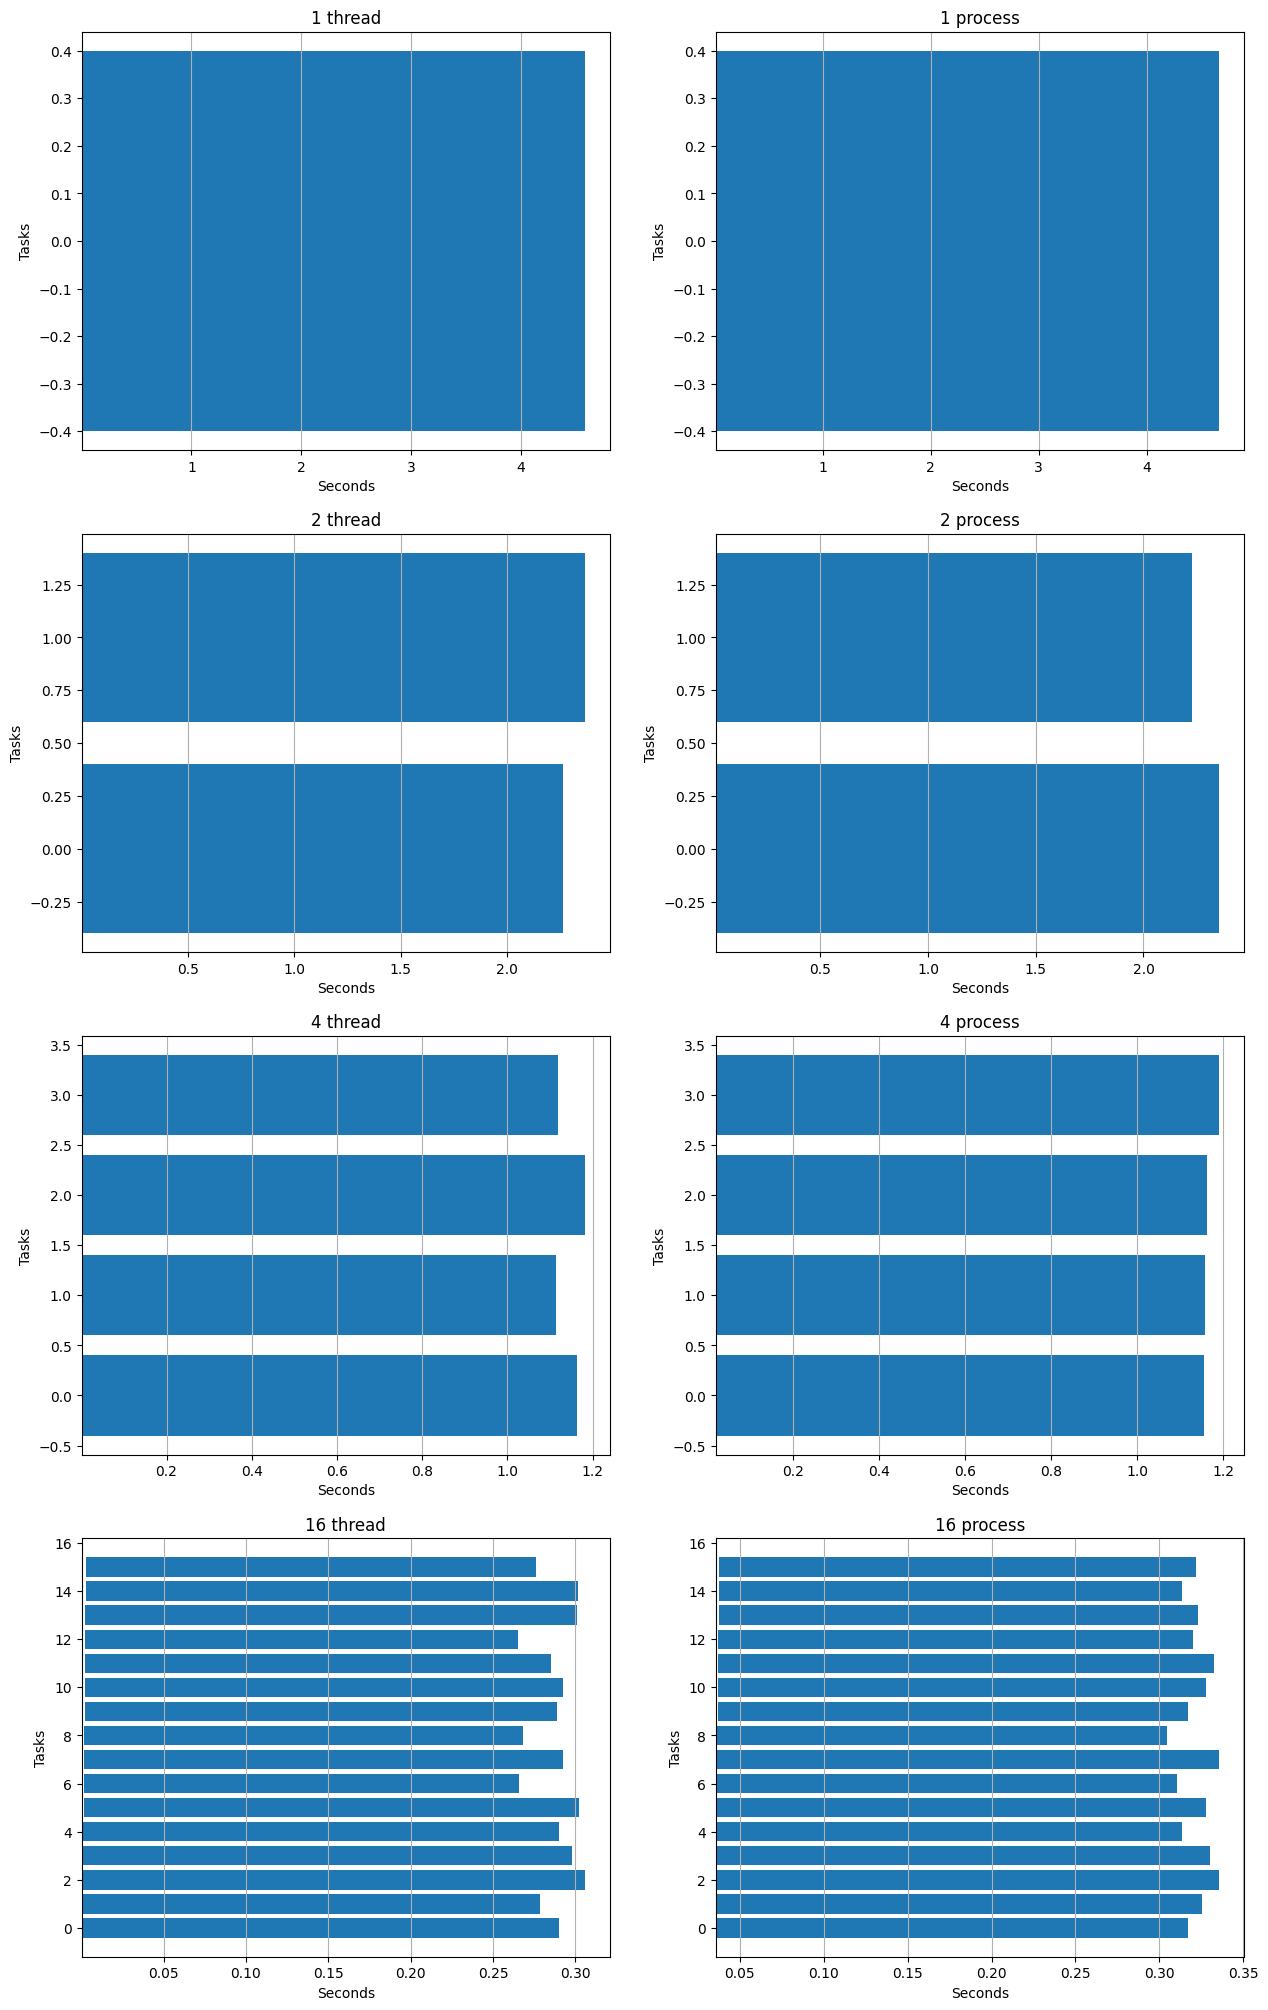

In [ ]:
from download import download
visualize_fn(download, ['https://raw.githubusercontent.com/Palladain/Deep_Python_2023/main/week06/Seminar_6_solved.ipynb'] * 32)

То есть при увеличении числа потоков и процессов время выполнения каждой задачи сокращалось.

#### Напишем файл

In [46]:
%%writefile io_heavy.py

import time

def io_heavy(x):
    writable_text, start_time = x
    start = time.time() - start_time
    f = open(f'output.txt', 'wt', encoding='utf-8')
    f.write(str(writable_text))
    f.close()
    stop = time.time() - start_time
    return start,stop

Overwriting io_heavy.py


Попытаемся записать большой текст в файл много раз и посмотрим время выполнения на разном числе потоков и процессов

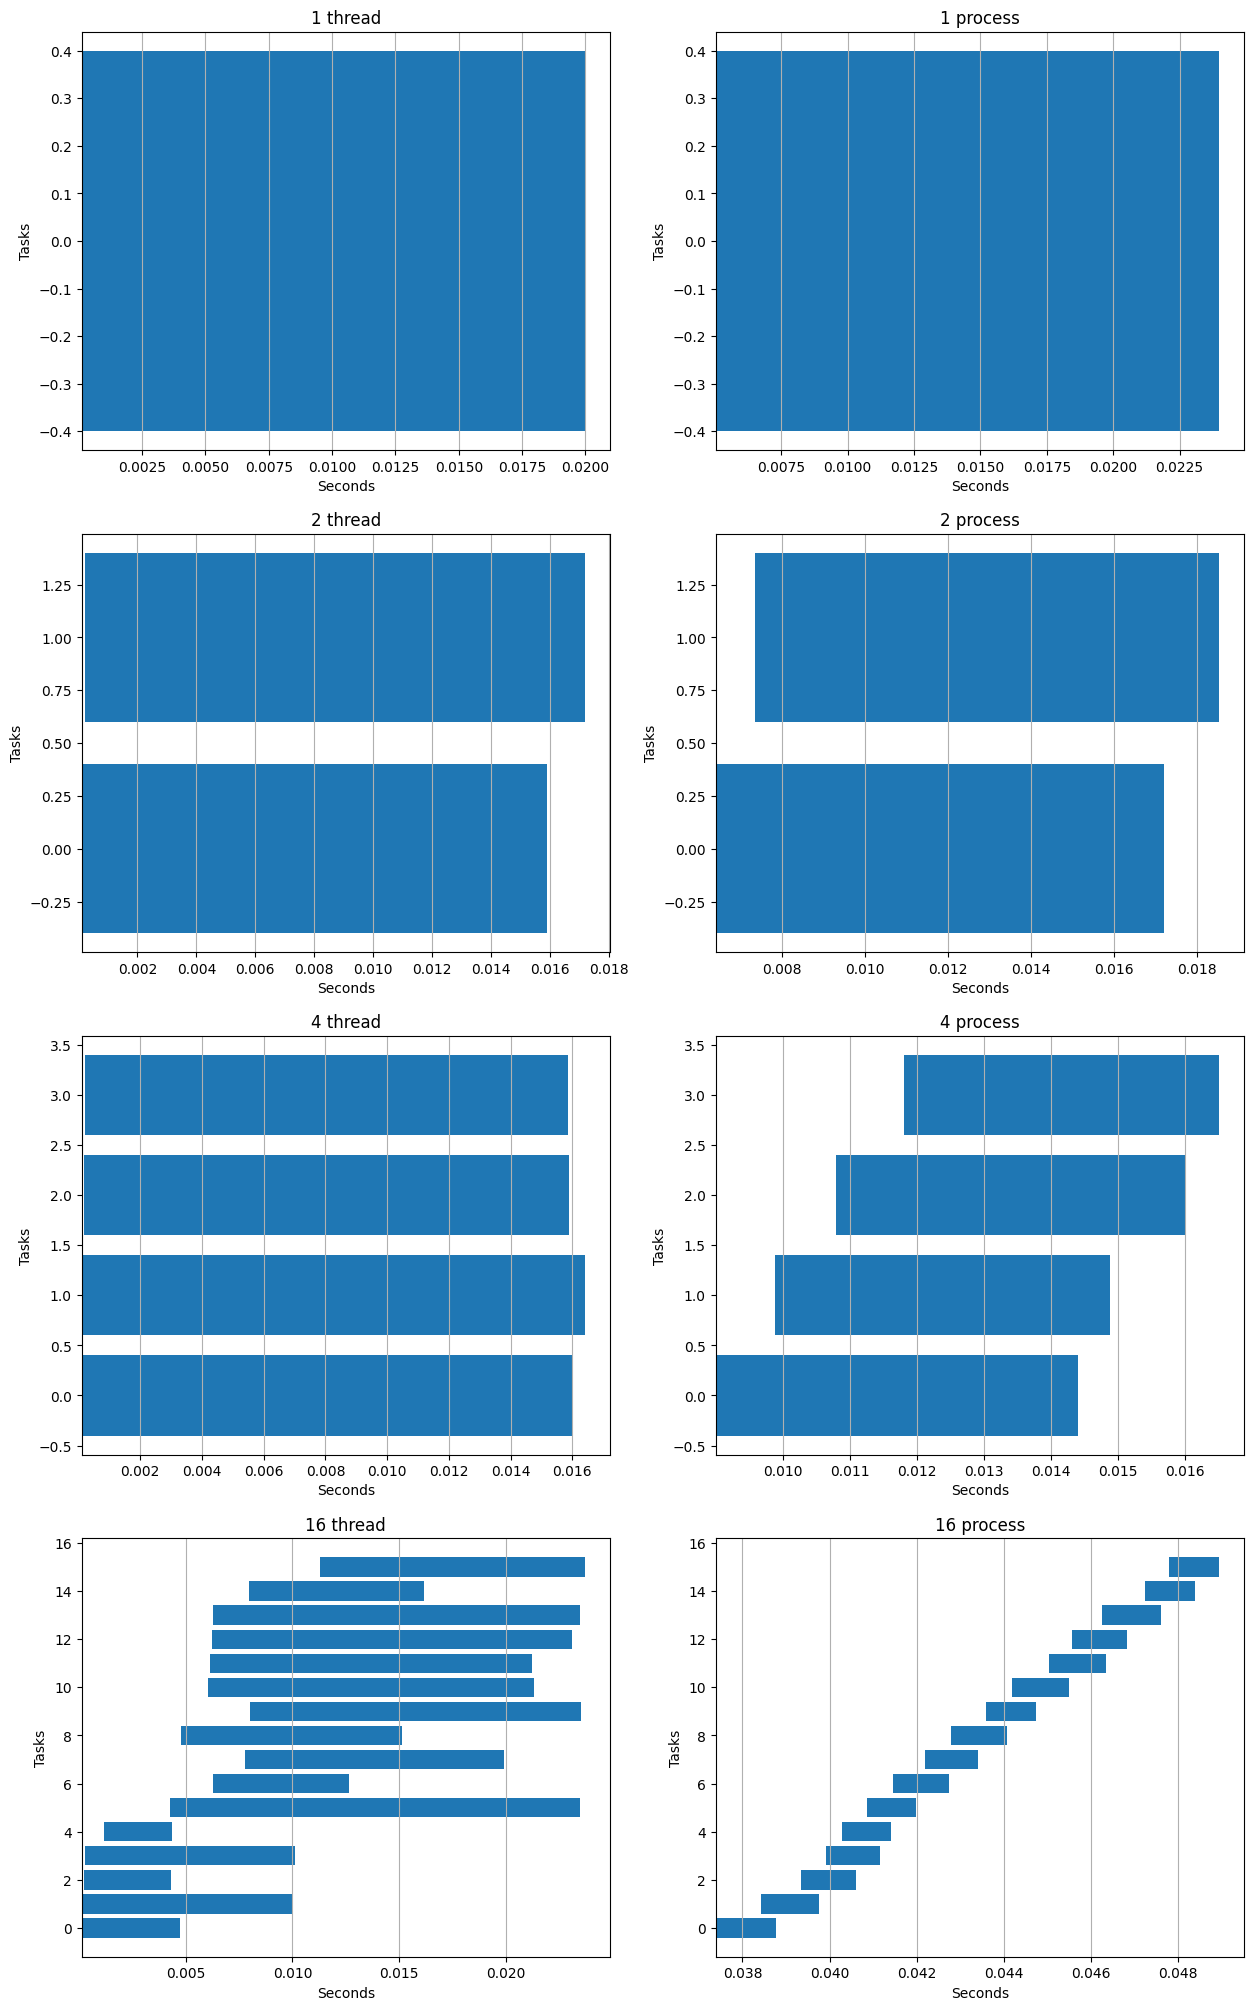

In [47]:
from io_heavy import io_heavy
TEXT = ''.join(random.choice(string.ascii_lowercase) for i in range(10**6))
visualize_fn(io_heavy, [TEXT] * 16)

Абстрактный Василий решил написать IO heavy функцию, но почему-то для нее threading не оказывается лучше. Это связано с тем, что чем больше потоков создаем, тем больше времени отнимают накладные расходы со стороны ОС, которая вынуждена переключать постоянно выполняющиеся потоки и распределять их между ограниченным количеством ядер. 

In [48]:
%%writefile io_heavy_broken.py

import time
import random
import string

def io_heavy_broken(x):
    _, start_time = x
    start = time.time() - start_time
    text = ''.join(random.choice(string.ascii_lowercase) for i in range(10**6))
    f = open(f'{text[:10]}.txt', 'w', encoding='utf-8')
    f.write(text)
    f.close()
    stop = time.time() - start_time
    return start,stop

Overwriting io_heavy_broken.py


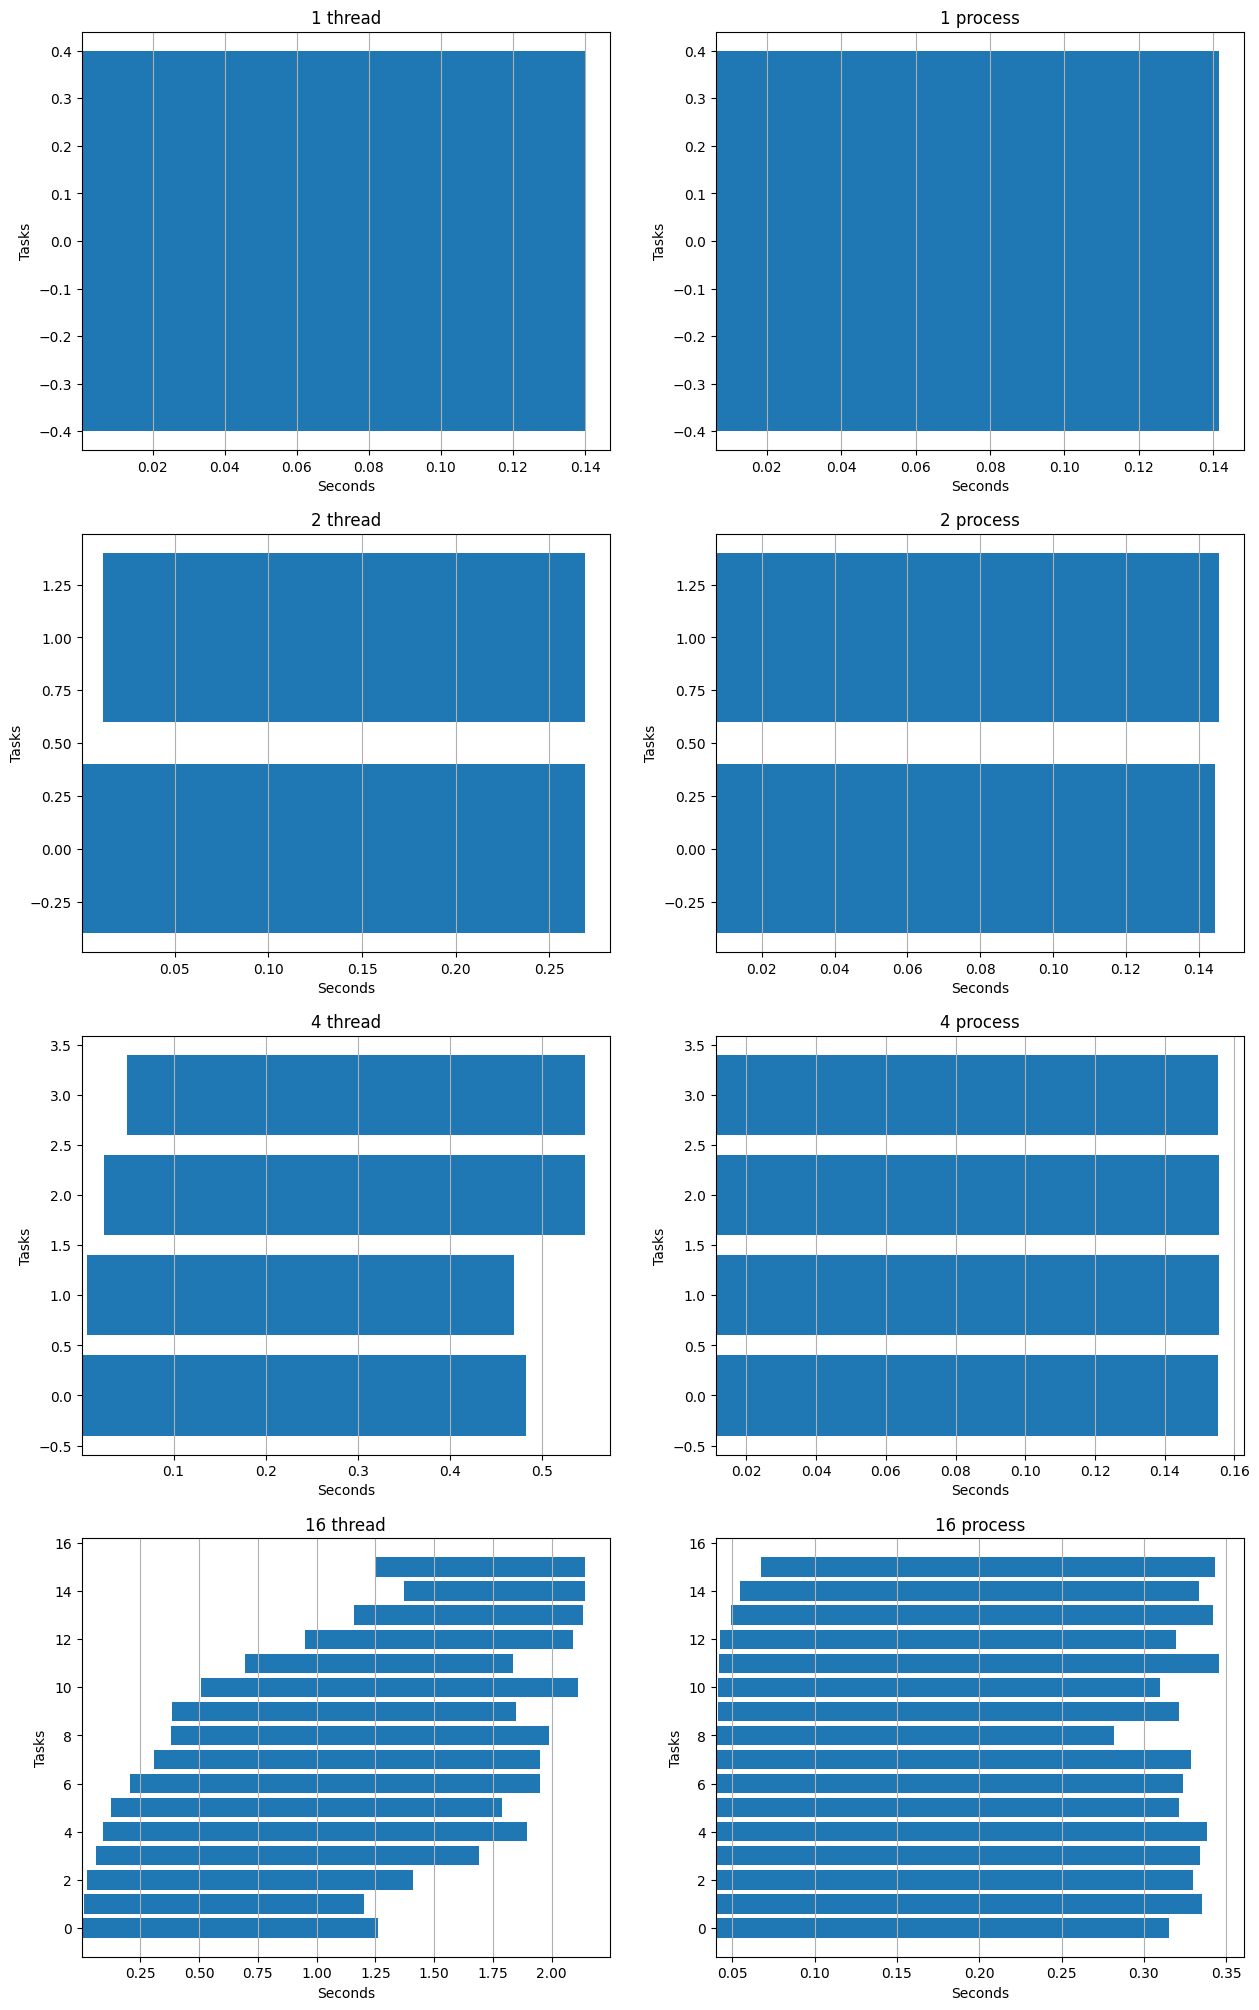

In [50]:
from io_heavy_broken import io_heavy_broken

visualize_fn(io_heavy_broken, [_] * 16)

Хинт: Важно следить за тем что именно IO-bounded операции распаралеливаются. То есть с ростом числа потоков и процессов время выполнения суммарное может выйти больше. Это связано как с GIL, так и с ростом накладных расходов со стороны ОС для поддержания параллелилзма

### CPU-heavy вычисления на чистом питоне

In [51]:
%%writefile is_prime.py
import math
import time

def is_prime(x):
    nums, start_time = x
    start = time.time() - start_time
    for num in nums:
      for i in range(2, math.ceil(math.sqrt(num))):
          if num % i == 0:
              break
    stop = time.time() - start_time
    return start, stop

Overwriting is_prime.py


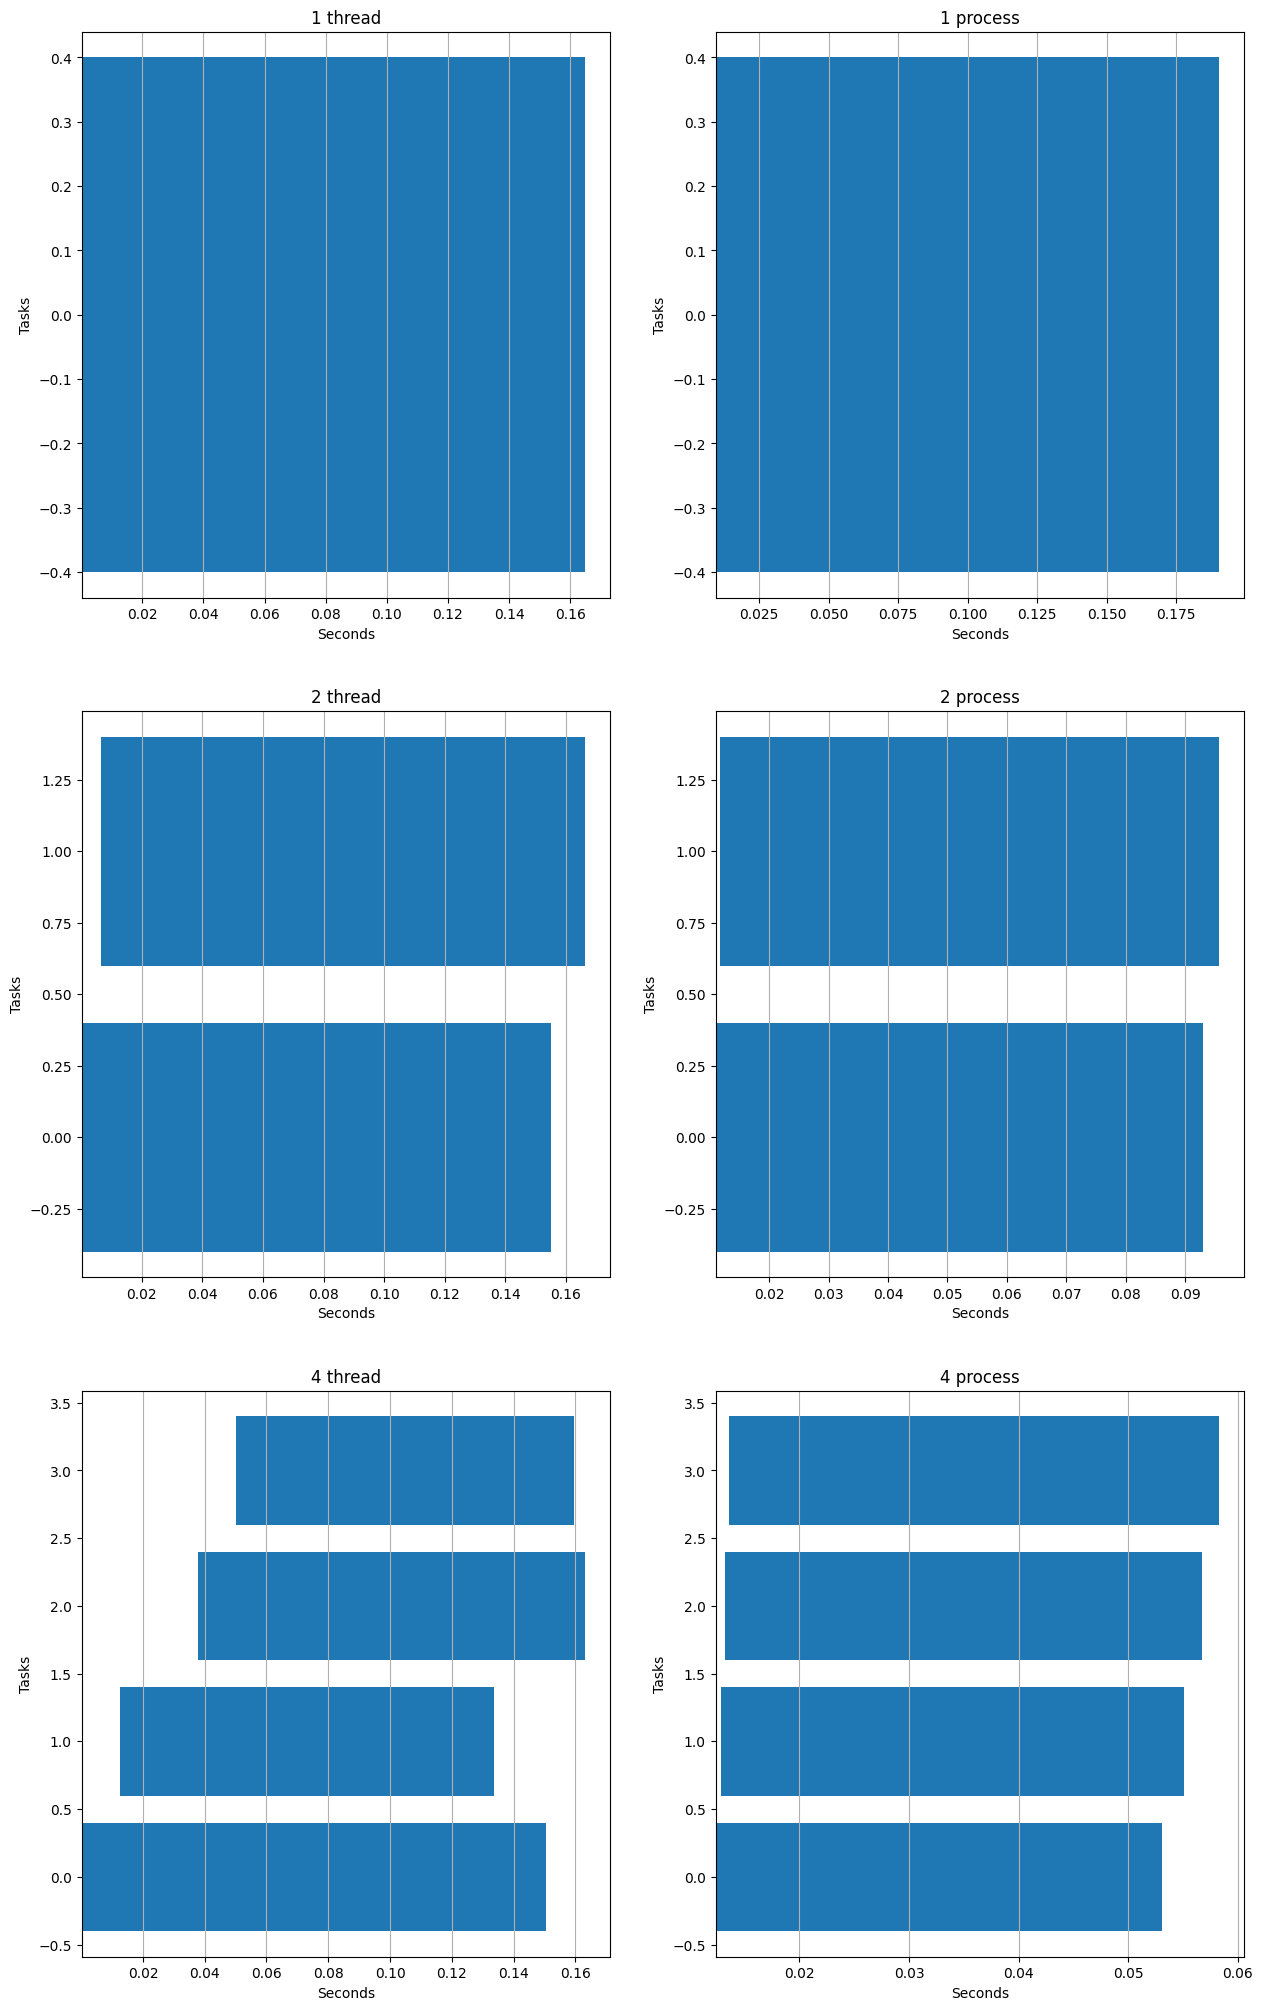

In [52]:
from is_prime import is_prime
visualize_fn(is_prime, list(range(400000, 500000)), [1, 2, 4])

Почему быстрее всего 2 процесса?

Это СPU-bounded вычисления, они подпадают под GIL и в колабе всего два CPU...

Еще видно что питон тут делает некий кэшинг, чем очень мешает нам увидеть желаемые графики, при этом cache shared между потоками, но не между процессами...

### Numpy и threading/multiprocessing

In [53]:
%%writefile exp.py
import numpy as np
import time

DIMS = 3000
SIZE = 16
a = np.random.rand(SIZE, DIMS,DIMS)


def exp(x):
    idx, start_time = x
    start = time.time() - start_time
    np.exp(a[idx])
    stop = time.time() - start_time
    return start, stop

Overwriting exp.py


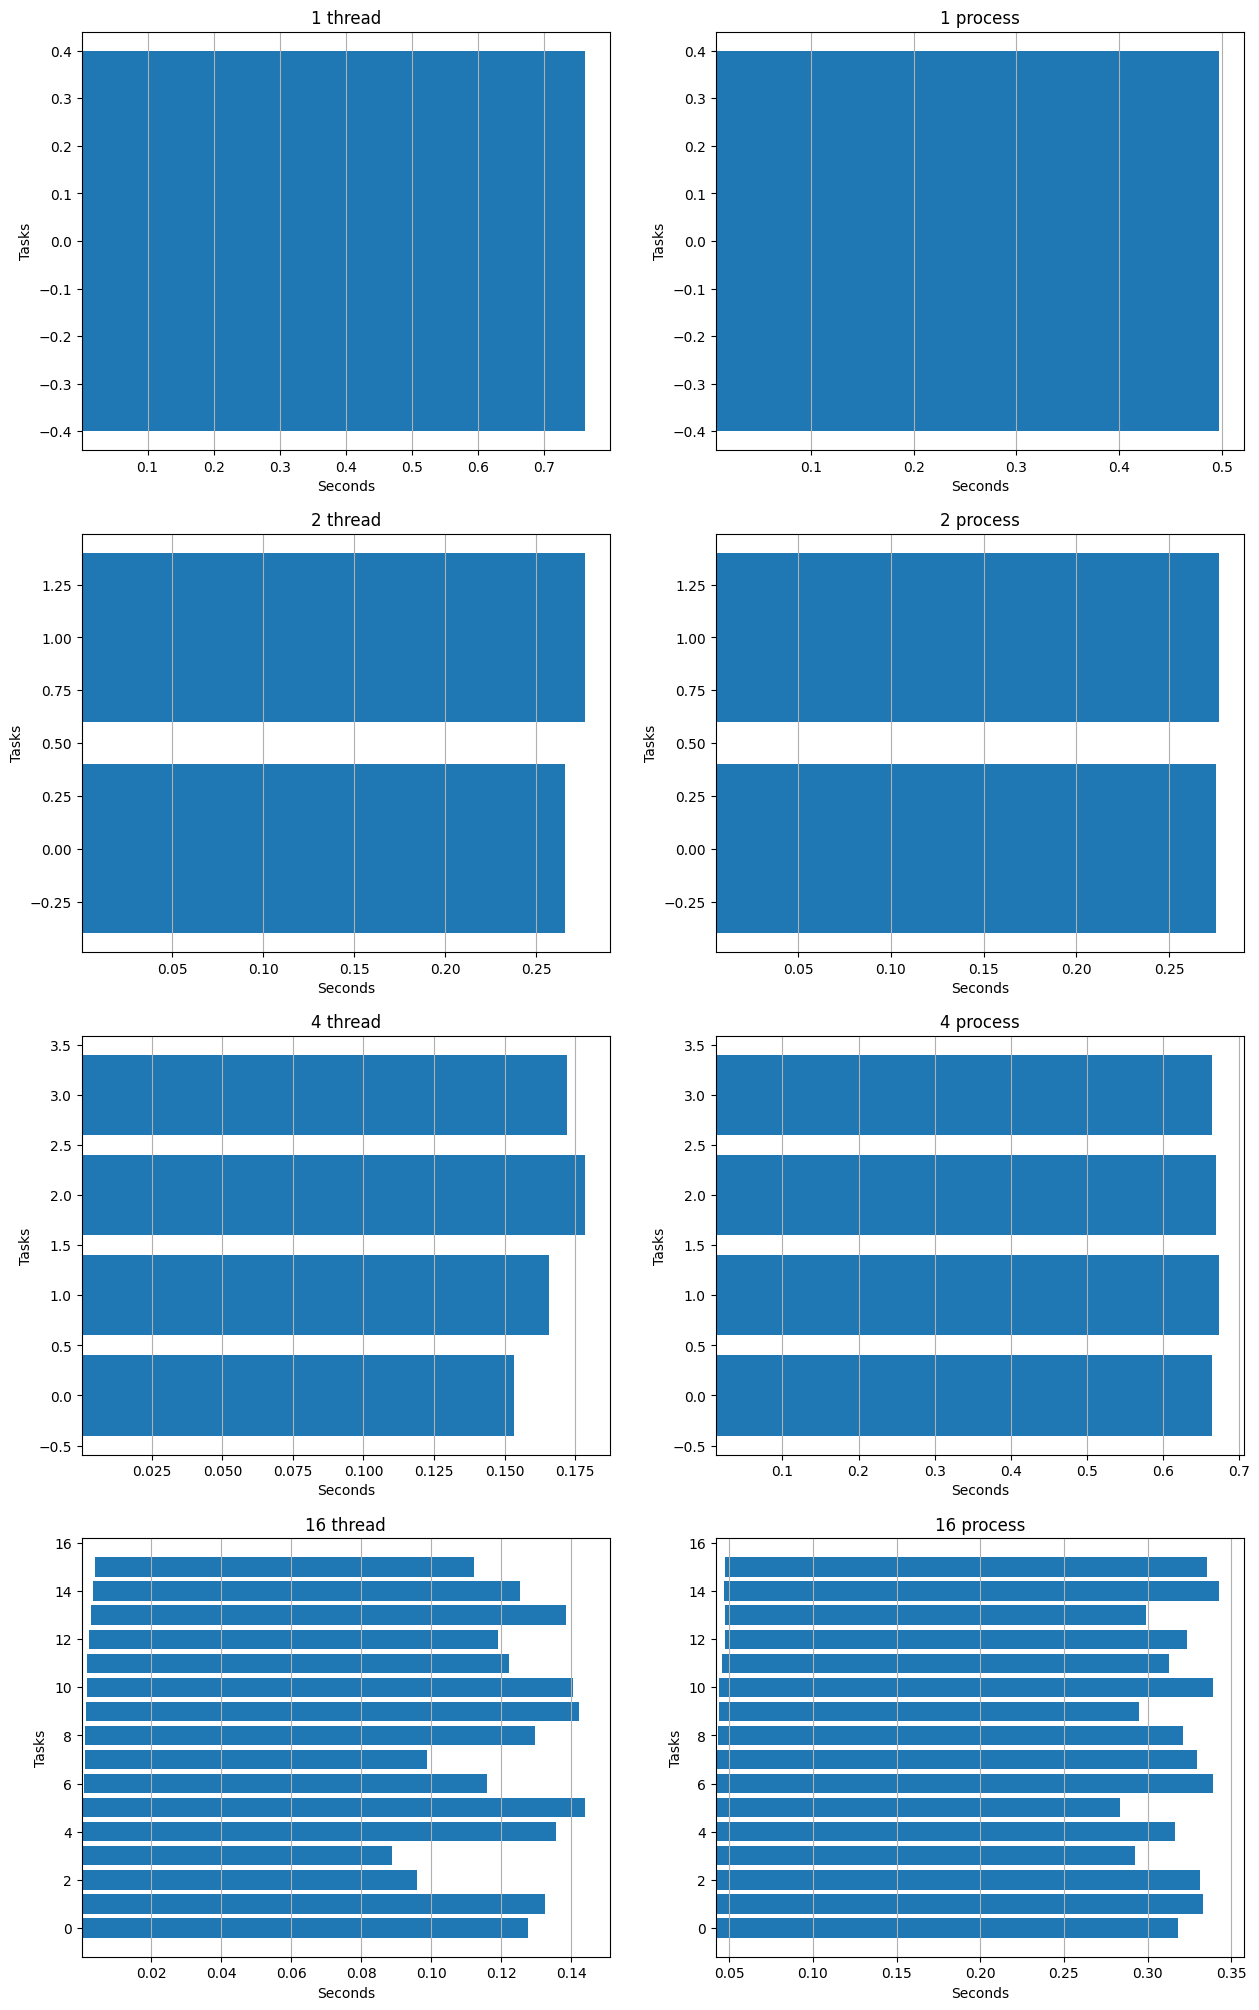

In [54]:
from exp import exp, a
visualize_fn(exp, [i for i in range(16)])

Почему не работает? Потому что некоторые (не все) вычисления в Numpy не блокируют GIL.

Но! обычно vectorized все равно быстрее:

In [55]:
%timeit np.exp(a)

325 ms ± 1.89 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### PIL: Более реальный пример, GIL уже играет роль

Давайте скажем что наша задача быстро читать картинки с диска, сжимать их и писать в другую папку на диске.

Как будем реализовывать?

In [56]:
import torchvision

In [57]:
torchvision.datasets.Flowers102(root='data/', split='train', download=True)

Dataset Flowers102
    Number of datapoints: 1020
    Root location: data/
    split=train

In [58]:
%%writefile process_image.py

import numpy as np
import time
from PIL import Image
import os

input_dir = 'data/flowers-102/jpg'
output_dir = 'data/flowers-102/compressed_jpg'
os.makedirs(output_dir, exist_ok=True)

def compress_image(input_path, output_path, factor=0.3):
    img = Image.open(input_path)
    width, height = img.size
    new_width = int(width * factor)
    new_height = int(height * factor)
    img = img.resize((new_width, new_height), Image.LANCZOS)
    img.save(output_path)

def process_image(x):
    image_files, start_time = x
    start = time.time() - start_time
    for image_file in image_files:
      input_path = os.path.join(input_dir, image_file)
      output_path = os.path.join(output_dir, image_file)
      compress_image(input_path, output_path, factor=0.5)
    stop = time.time() - start_time
    return start, stop

Overwriting process_image.py


In [59]:
import os
input_dir = 'data/flowers-102/jpg'
output_dir = 'data/flowers-102/compressed_jpg'
all_files = os.listdir(input_dir)[:600]

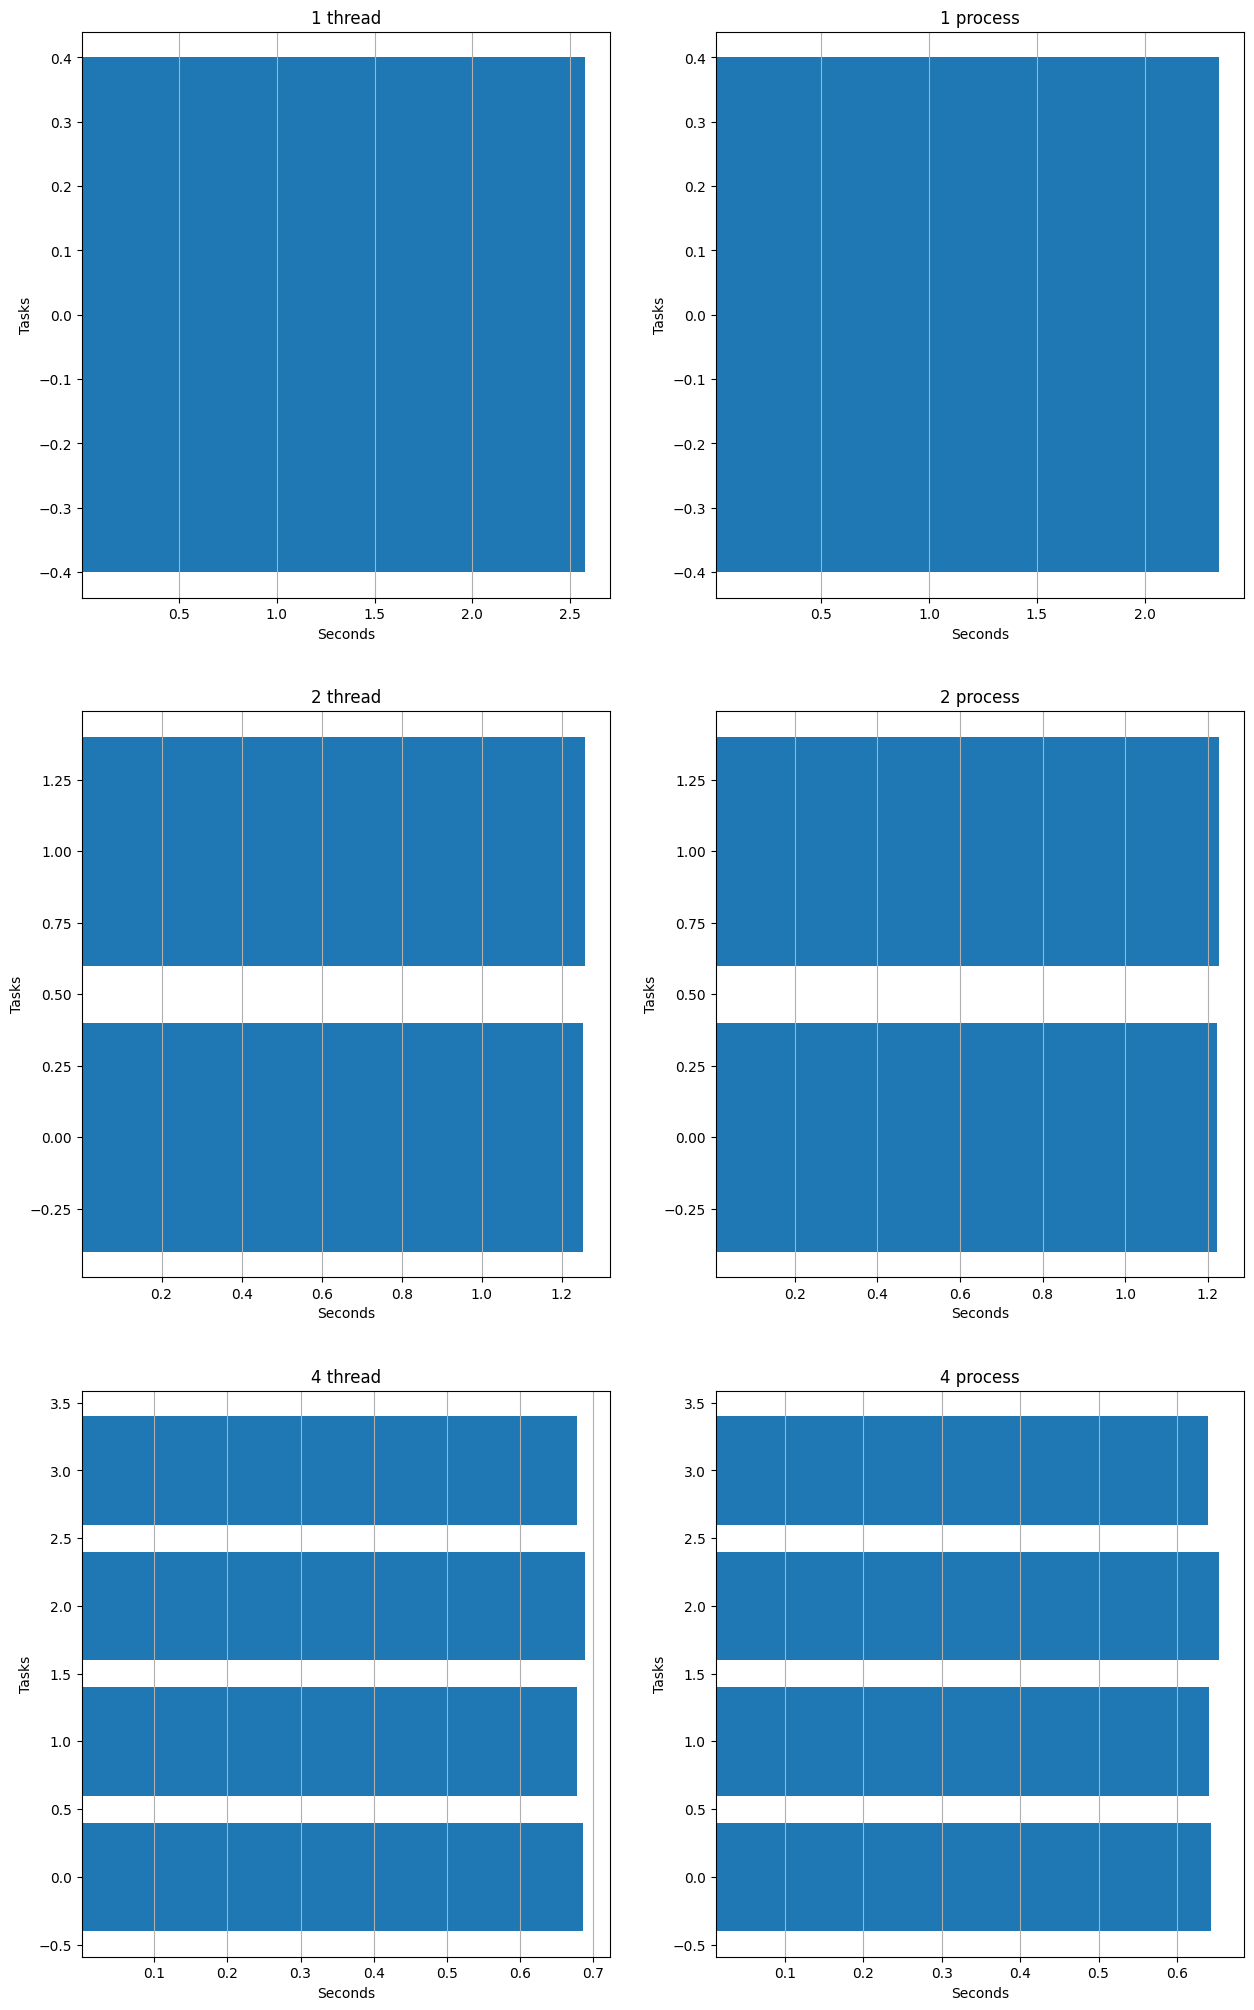

In [60]:
from process_image import process_image
# Запусти меня и предложи угадать результаты, занимает секунд 30 :)
visualize_fn(
    process_image,
    all_files,
    jobs=[1, 2, 4]
)

## Вывод

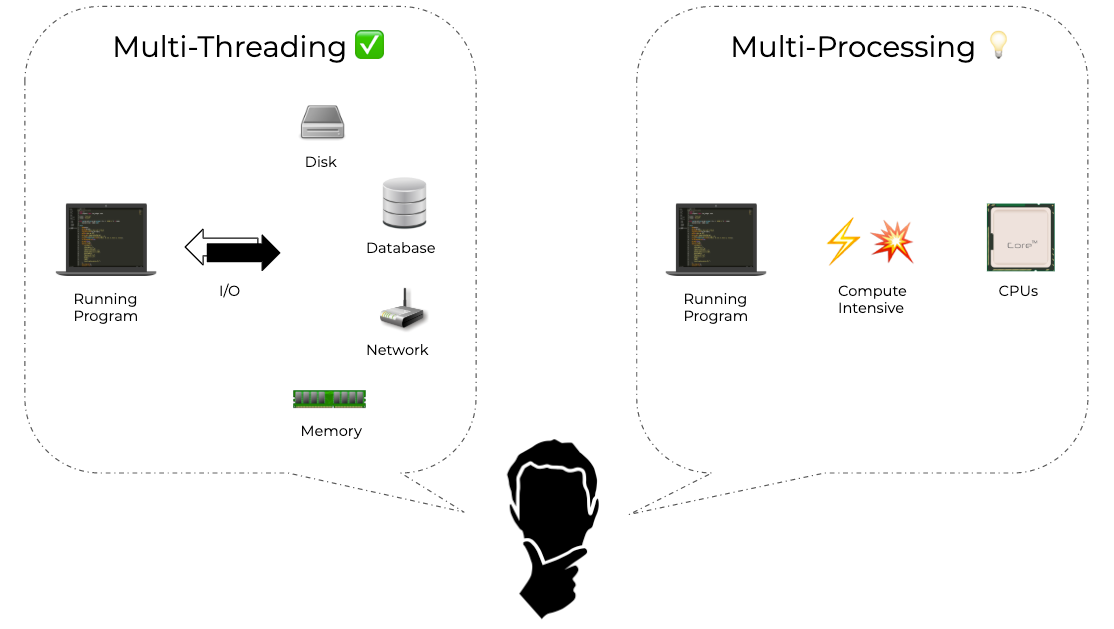

# Субинтерпретаторы

в 3.12 питоне появились субинтерпретаторы -- которая появился как вариант параллелизма.

* Один питонячий процесс может создавать несколько интерпретаторов, у каждого свой GIL
* GIL больше не общий для всего процесса, а отдельный для каждого интерпретатора
* Это что то между вариантом между threading (общая память, один GIL) и multiprocessing (разные процессы, разная память).


In [61]:
!pyenv local 3.13t-dev
!python --version

Python 3.13.7+


In [62]:
import _interpreters as xx

sub_id = xx.create()
print("ID субинтерпретатора:", sub_id)

# выполняем строку кода в нём
xx.run_string(sub_id, "print('Привет!!!!')")

ID субинтерпретатора: 1
Привет!!!!


Пока это игрушка, но в будущем на новых версиях появится целые разделы параллелизма, и новая ветвь выполнения параллельных инструкций.